In [42]:
import multiprocessing
import time
import random

def productor(cola):
    for i in range(10):
        dato = random.randint(1, 100)
        cola.put(dato)
        print(f"Productor: Dato {dato} enviado a la cola")
        time.sleep(random.random())  # Simula algo de trabajo

def consumidor(cola, id):
    while True:
        dato = cola.get()
        if dato is None:  # Señal para terminar
            break
        resultado = dato * dato
        print(f"Consumidor {id}: Dato {dato}, Resultado: {resultado}")
        time.sleep(random.random())  # Simula algo de trabajo

if __name__ == "__main__":
    cola = multiprocessing.Queue()
    num_consumidores = 3

    # Crear y iniciar el proceso productor
    p_productor = multiprocessing.Process(target=productor, args=(cola,))
    p_productor.start()

    # Crear y iniciar los procesos consumidores
    consumidores = []
    for i in range(num_consumidores):
        p_consumidor = multiprocessing.Process(target=consumidor, args=(cola, i))
        consumidores.append(p_consumidor)
        p_consumidor.start()

    # Esperar a que el productor termine
    p_productor.join()

    # Enviar señales de terminación a los consumidores
    for _ in range(num_consumidores):
        cola.put(None)

    # Esperar a que los consumidores terminen
    for p_consumidor in consumidores:
        p_consumidor.join()

    print("Proceso principal terminado")

Productor: Dato 59 enviado a la colaConsumidor 0: Dato 59, Resultado: 3481

Productor: Dato 77 enviado a la cola
Consumidor 1: Dato 77, Resultado: 5929
Productor: Dato 58 enviado a la cola
Consumidor 2: Dato 58, Resultado: 3364
Productor: Dato 40 enviado a la colaConsumidor 0: Dato 40, Resultado: 1600

Productor: Dato 88 enviado a la cola
Consumidor 1: Dato 88, Resultado: 7744
Productor: Dato 27 enviado a la cola
Consumidor 2: Dato 27, Resultado: 729
Productor: Dato 14 enviado a la colaConsumidor 0: Dato 14, Resultado: 196

Productor: Dato 66 enviado a la colaConsumidor 1: Dato 66, Resultado: 4356

Productor: Dato 97 enviado a la colaConsumidor 0: Dato 97, Resultado: 9409

Productor: Dato 35 enviado a la colaConsumidor 2: Dato 35, Resultado: 1225

Proceso principal terminado


In [48]:
import tensorflow as tf
import numpy as np
import threading
import sys
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [54]:
# Carga de datos de validacion
testing_set = sys.argv[0] = "/home/arthur1/Documentos/GitHub/Prueba/Datos/Salida/Datos_validacion_TCGA_matriz.npy"
test_sample = np.load ( testing_set )
x_train = test_sample.reshape ( (test_sample.shape[0], 100, 100, 1) ) # no. of samples, x pixels, y pixels, no. of files

# Carga de etiquetas de datos de validacion
testing_label = sys.argv[0] = "/home/arthur1/Documentos/GitHub/Prueba/Datos/Salida/Datos_validacion_TCGA_etiquetas.npy"
test_label = np.load ( testing_label )
test_label_compare = test_label
y_train = to_categorical (test_label,num_classes=12 )

In [55]:
training_set = sys.argv[0] = "/home/arthur1/Documentos/GitHub/Prueba/Datos/Salida/Datos_entrenamiento_TCGA_matriz.npy" ### "Input data npy file" 
x_sample = np.load ( training_set )
x_test = x_sample.reshape ((x_sample.shape[0], 100, 100,1)) # No. de muestras, Longitud, Ancho, No. de filtros

training_label = sys.argv[0] = "/home/arthur1/Documentos/GitHub/Prueba/Datos/Salida/Datos_entrenamiento_TCGA_etiquetas.npy" ### "Input label npy file" 
y_label = np.load ( training_label )
y_test = to_categorical(y_label, num_classes=12)

In [64]:
# Dividir en entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [68]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.BatchNormalization(axis=2,epsilon=1e-5),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),padding=("same")),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(axis=2,epsilon=1e-5),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),padding=("same")),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(axis=2,epsilon=1e-5),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),padding=("same")),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(600, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()
accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

# Métricas para validación
val_loss_fn = tf.keras.losses.CategoricalCrossentropy()
val_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()


# Almacenar métricas
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 5
batch_size = 64
steps_per_epoch = len(x_train) // batch_size
val_steps = len(x_val) // batch_size

In [69]:
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    for step in range(steps_per_epoch):
        x_batch = x_train[step * batch_size: (step + 1) * batch_size]
        y_batch = y_train[step * batch_size: (step + 1) * batch_size]

        with tf.GradientTape() as tape:
            predictions = model(x_batch, training=True)
            loss = loss_fn(y_batch, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        accuracy_metric.update_state(y_batch, predictions)

        train_losses.append(loss.numpy())
        train_accuracies.append(accuracy_metric.result().numpy())

        accuracy_metric.reset_state()

    # Validación
    val_loss = 0.0
    val_accuracy = 0.0

    for step in range(val_steps):
        x_batch_val = x_val[step * batch_size: (step + 1) * batch_size]
        y_batch_val = y_val[step * batch_size: (step + 1) * batch_size]

        val_predictions = model(x_batch_val, training=False)
        val_loss += val_loss_fn(y_batch_val, val_predictions)
        val_accuracy_metric.update_state(y_batch_val, val_predictions)

    val_losses.append((val_loss / val_steps).numpy())
    val_accuracies.append(val_accuracy_metric.result().numpy())
    val_accuracy_metric.reset_state()

    print(f"  Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")
    print(f"  Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")


Epoch 1/5
  Train Loss: 2.4182, Train Accuracy: 0.0312
  Val Loss: 2.4114, Val Accuracy: 0.1953
Epoch 2/5
  Train Loss: 2.0605, Train Accuracy: 0.2656
  Val Loss: 2.2463, Val Accuracy: 0.2539
Epoch 3/5
  Train Loss: 1.0209, Train Accuracy: 0.6719
  Val Loss: 1.9743, Val Accuracy: 0.2891
Epoch 4/5
  Train Loss: 0.4506, Train Accuracy: 0.8125
  Val Loss: 1.4641, Val Accuracy: 0.4896
Epoch 5/5
  Train Loss: 0.1867, Train Accuracy: 0.9375
  Val Loss: 0.9276, Val Accuracy: 0.7474


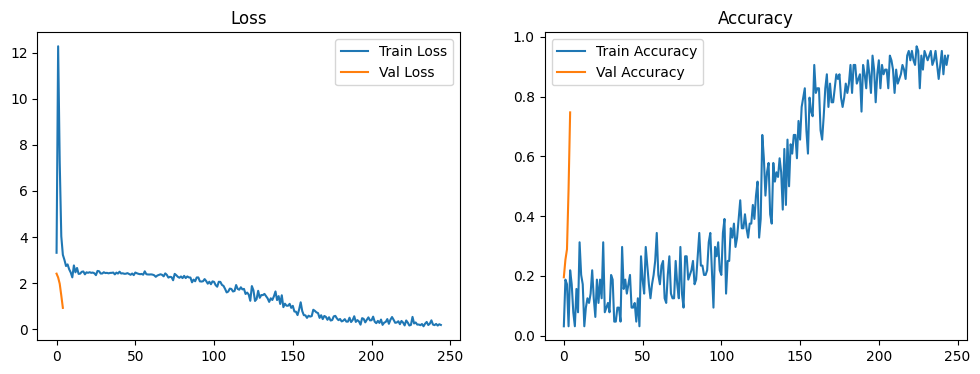

In [70]:
# Graficar
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


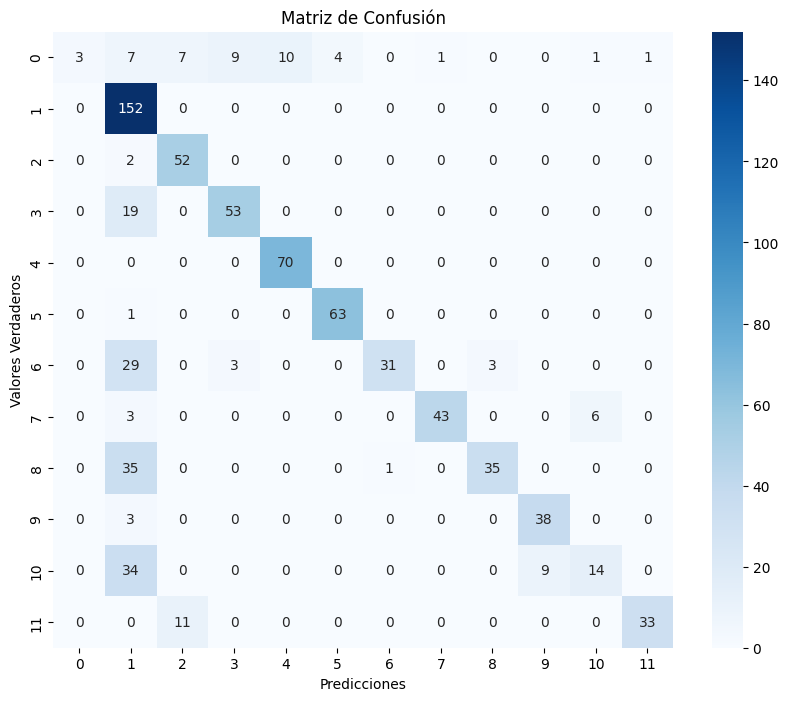

In [72]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Realizar predicciones en el conjunto de validación
y_pred_prob = model.predict(x_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.title('Matriz de Confusión')
plt.show()